In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import desc

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
#get a list of the columns in each table

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [10]:


# Collect the last 12 months of data in the table
# IE '2016-08-23' to '2017-08-23' (end of recorded data in the table)
import datetime
latest_year = datetime.datetime.strptime('2016-08-23', '%Y-%m-%d')

historic_df = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= latest_year).all()
session.query(Measurement.date).order_by(desc(Measurement.date)).first()

('2017-08-23')

In [11]:
# Create a data frame with the data, clean up the column names and make sure the data types are correct
historic_rain_df = pd.DataFrame(historic_df, columns=['date', 'prcp'])
historic_rain_df.set_index('date', inplace = True)
historic_rain_df = historic_rain_df.rename(columns = {'prcp':'precipitation'})
historic_rain_df['precipitation'] = pd.to_numeric(historic_rain_df['precipitation'])
historic_rain_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


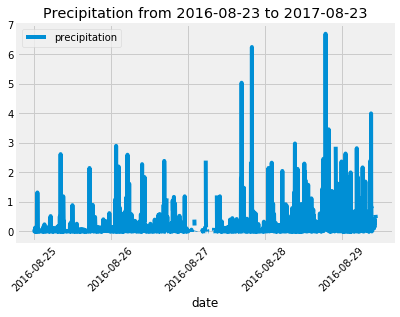

In [12]:
ax = historic_rain_df.plot()
ax.set_xticklabels(historic_rain_df.index,rotation=45)
ax.set_title("Precipitation from 2016-08-23 to 2017-08-23")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

summary_prcp_df = (historic_rain_df.describe().reset_index().
                    rename(columns={'index':'statistic', 'prcp':'precipitation'}).copy())
summary_prcp_df['precipitation']=summary_prcp_df['precipitation'].round(decimals=2)

summary_prcp_df

 

,statistic,precipitation
0,count,2015.00
1,mean,0.18
2,std,0.46
3,min,0.00
4,25%,0.00
5,50%,0.02
6,75%,0.13
7,max,6.70


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()


9

In [15]:
conn = engine.connect()
observations_df = pd.read_sql("select Station.station, Station.name, count(Measurement.station) AS observations from Station join Measurement on Station.station=Measurement.station group by Station.station order by observations desc", conn)
observations_df

,station,name,observations
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


conn = engine.connect()
busiest_station_df = (pd.read_sql("select min(tobs), max(tobs), avg(tobs) from Measurement where station ='USC00519281'", conn))
busiest_station_df

 

,min(tobs),max(tobs),avg(tobs)
0,54.0,85.0,71.663781


Text(0.5, 1.0, 'Temperature Observations')

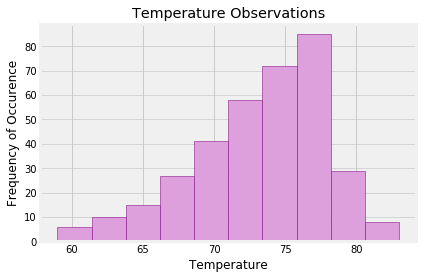

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

conn = engine.connect()
busiest_station_df = (pd.read_sql("select date, tobs from Measurement where station ='USC00519281' and date > '2016-08-23'", conn))
busiest_station_df.hist(column='tobs', color='plum', ec='purple')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Frequency of Occurence')
plt.title('Temperature Observations')
 
 
 

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-12-28', '2017-01-03'))



[(62.0, 69.81395348837209, 77.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


mytrip = calc_temps('2015-12-28', '2016-01-03')
mytrip


[(62.0, 70.6923076923077, 77.0)]

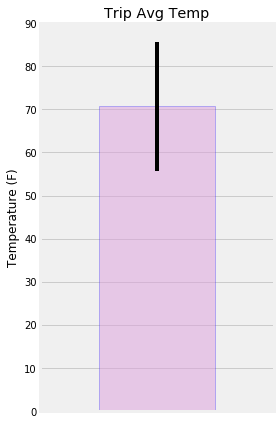

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Create a dataframe with the calculated tmin, tavg, and tmax values
mytrip_df = pd.DataFrame(mytrip, columns=['tmin', 'tavg', 'tmax'])

mytrip_df.plot.bar(y='tavg', yerr=(mytrip_df['tmax'] - mytrip_df['tmin']), title='Trip Avg Temp', color='plum', ec='blue', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/Trip Temps.png")
plt.show()


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


conn = engine.connect()
station_rain = (pd.read_sql("select m.station, s.name, elevation,latitude, longitude, sum(prcp) AS 'total rainfall' from Measurement m join Station s on m.station = s.station where date between '2015-12-28' AND '2017-01-03' group by m.station order by 'total rainfall' desc", conn))
station_rain

 

,station,name,elevation,latitude,longitude,total rainfall
0,USC00513117,"KANEOHE 838.1, HI US",14.6,21.42340,-157.80150,53.04
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",7.0,21.52130,-157.83740,27.52
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",152.4,21.33310,-157.80250,163.04
3,USC00517948,"PEARL CITY, HI US",11.9,21.39340,-157.97510,2.97
4,USC00519281,"WAIHEE 837.5, HI US",32.9,21.45167,-157.84889,80.68
5,USC00519397,"WAIKIKI 717.2, HI US",3.0,21.27160,-157.81680,16.16
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",19.5,21.33556,-157.71139,30.83
